# Project Vrijtap - Artificial Intelligence

**Author: Brian van den Berg**

This notebook serves as a training file to train a Neural Network on training images for use in the Raspberry Pi. The images are pre-processed minimally by making the images grayscale, but besides that, it's quite a simple Neural Network that is meant to be trained on situations where the tap can or cannot tap. The biggest reason for using a DNN, is because we wanted to make the tap stop when someone started tempering with it.

In [10]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Input

This chapter contains the import of training data to use on the model.

### Paths Locations

This code block finds all the images in the data folder recusively.

In [11]:
# Specify the input
dataset_folder = 'data'
image_extensions=('.jpg', '.jpeg', '.png')

# Get image paths
image_paths = []
for foldername, __, filenames in os.walk(dataset_folder):
    for filename in filenames:
        if filename.lower().endswith(image_extensions):
            image_paths.append(os.path.join(foldername, filename))

### Train/Test Split

I deviated from the rule of thumb in how much data should be used as testing data, because I wanted to use as much data as possible for training. So instead of the normal 70/30 train/test split, I went with an 80/20 split instead.

Image Shape: (64, 64)
Class: 0


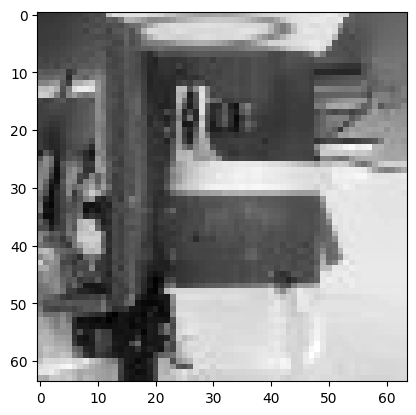

In [12]:
# Load the dataset as grayscale images
X = np.array(list(map(lambda path: cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY), image_paths)))
X = X / 255.0
Y = np.array([1 if 'cup' in path else 0 for path in image_paths])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display one selected image
image_selected = 5
print(f'Image Shape: {X_train[image_selected].shape}')
print(f'Class: {Y_train[image_selected]}')
plt.imshow(X_train[image_selected], cmap='gray')
plt.show()

## Model

The model is relatively simple. Since we're dealing with images, we're using a 2D convolutional network on the input layers. After flattening the captured features, they are then passed to a single hidden layers that contains weights trained to recognize correct tapping situations and finally, a single sigmoid activation detirmines how sure the model is of a picture having to be classified as ready or not ready.

In [13]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

## Training

The hyperparameter of 37 epochs was chosen using the training history graph plotted down below. The testing set was used as validation data in order for me to waste as little data as possible while being able to see the performance of the model on the testing set throughout epochs.

In [14]:
# Train the model with less verbosity
history = model.fit(X_train, Y_train, epochs=37, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/37
17/17 - 1s - loss: 0.6585 - accuracy: 0.6827 - val_loss: 0.5887 - val_accuracy: 0.7154 - 718ms/epoch - 42ms/step
Epoch 2/37
17/17 - 0s - loss: 0.5042 - accuracy: 0.7846 - val_loss: 0.4830 - val_accuracy: 0.6846 - 253ms/epoch - 15ms/step
Epoch 3/37
17/17 - 0s - loss: 0.4238 - accuracy: 0.7942 - val_loss: 0.3146 - val_accuracy: 0.9077 - 249ms/epoch - 15ms/step
Epoch 4/37
17/17 - 0s - loss: 0.2684 - accuracy: 0.9096 - val_loss: 0.2073 - val_accuracy: 0.9308 - 251ms/epoch - 15ms/step
Epoch 5/37
17/17 - 0s - loss: 0.2163 - accuracy: 0.9288 - val_loss: 0.2098 - val_accuracy: 0.9231 - 248ms/epoch - 15ms/step
Epoch 6/37
17/17 - 0s - loss: 0.1640 - accuracy: 0.9519 - val_loss: 0.1659 - val_accuracy: 0.9462 - 253ms/epoch - 15ms/step
Epoch 7/37
17/17 - 0s - loss: 0.1449 - accuracy: 0.9346 - val_loss: 0.1101 - val_accuracy: 0.9692 - 249ms/epoch - 15ms/step
Epoch 8/37
17/17 - 0s - loss: 0.0954 - accuracy: 0.9692 - val_loss: 0.0830 - val_accuracy: 0.9692 - 248ms/epoch - 15ms/step
Epoch 9/

## Evaluation

### Train/Test History

Down below, you can see the performance plotted over training epochs. By doing this, I detirmined that 37 is the optimal point to stop training.

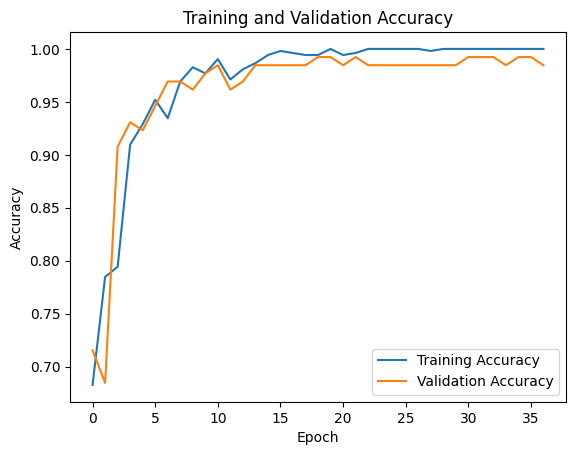

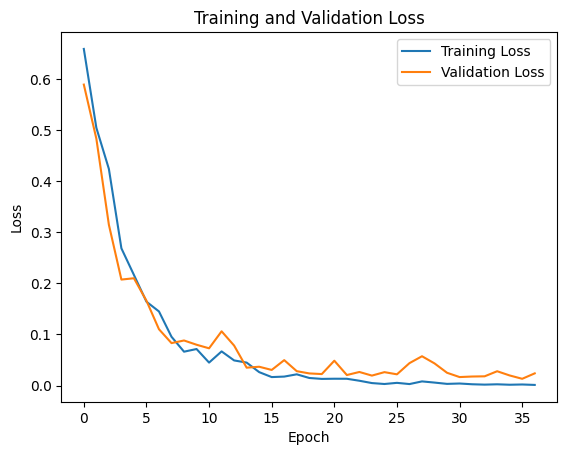

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion Matrix

The confusion matrix shows the amount of True positives and negatives, but also the amount false positives and negatives. This shows that our model is very good at detirming the state.

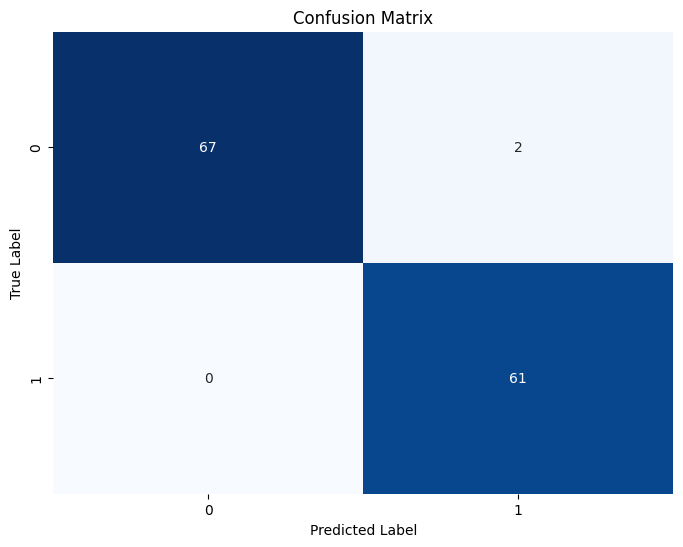

rtf: 0.55ms


In [16]:
# Predict values for the test set
startTime = time.time()
Y_pred = model.predict(X_test, verbose=0)
rtf = (time.time() - startTime) * 1000 / len(Y_pred)

# Convert the predicted probabilities to binary class labels (0 or 1)
Y_pred_classes = (Y_pred > 0.5).astype(int)

# Confusion Matrix
conf_mat = confusion_matrix(Y_test, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the RTF score for classifying images
print(f'rtf: {rtf:.2f}ms')

### Classification Report

As you can see in the classification report down below, the model is very adept at detirming wether or not the tap should start or stop. This is good, as we want the system to be as trustworthy as possible. In the implementation, we even chose to use a treshold of 0.7, meaning that the system is even more cautious in giving a go.

In [17]:
# Classification Report
classification_rep = classification_report(Y_test, Y_pred_classes)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        69
           1       0.97      1.00      0.98        61

    accuracy                           0.98       130
   macro avg       0.98      0.99      0.98       130
weighted avg       0.99      0.98      0.98       130



## Saving

To use this model on the raspberry pi, the model is saved as a .h5 file which can be loaded into other applications. The only important thing to take away is that the image shape and preprocessing should match the data that was being trained on.

In [18]:
# Save the trained model
model.save('model.h5', save_format='h5')

/home/brian-vdb/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
